In [2]:
import numpy
import os
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [3]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

405 188


### 2. Set key parameters

In [4]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [5]:
model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
for layer in model.layers[:10]:
    print(layer)
    layer.trainable = False

In [6]:
x = model.output
x = Flatten()(x)

predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

C:\Users\mufad\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 405 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [8]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("parking_spots_model.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=1, mode='auto', baseline=0.93)


In [9]:
### Start training!

history_object = model_final.fit(
train_generator,
epochs = epochs,
validation_data = validation_generator,
callbacks = [checkpoint, early])

Epoch 1/15
13/13 [==============================] - 22s 2s/step - loss: 0.6093 - accuracy: 0.6346 - val_loss: 0.4390 - val_accuracy: 0.7979

Epoch 00001: accuracy improved from -inf to 0.63457, saving model to parking_spots_model.h5
Epoch 2/15
13/13 [==============================] - 19s 2s/step - loss: 0.3976 - accuracy: 0.7827 - val_loss: 0.3511 - val_accuracy: 0.8457

Epoch 00002: accuracy improved from 0.63457 to 0.78272, saving model to parking_spots_model.h5
Epoch 3/15
13/13 [==============================] - 19s 1s/step - loss: 0.2932 - accuracy: 0.9160 - val_loss: 0.3074 - val_accuracy: 0.8777

Epoch 00003: accuracy improved from 0.78272 to 0.91605, saving model to parking_spots_model.h5
Epoch 4/15
13/13 [==============================] - 19s 1s/step - loss: 0.2279 - accuracy: 0.9309 - val_loss: 0.2819 - val_accuracy: 0.8830

Epoch 00004: accuracy improved from 0.91605 to 0.93086, saving model to parking_spots_model.h5
Epoch 5/15
13/13 [==============================] - 19s 1s/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


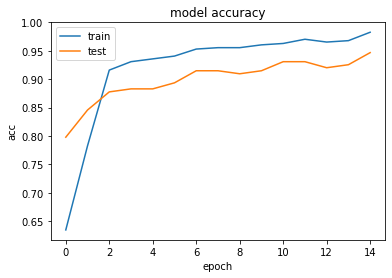

In [10]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

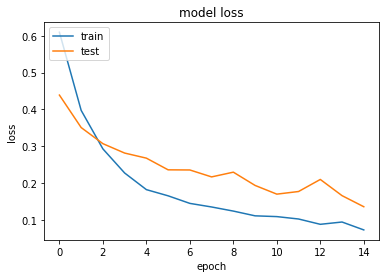

In [11]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()